In [5]:
# !unzip output.zip

unzip:  cannot find or open data/output.zip, data/output.zip.zip or data/output.zip.ZIP.


In [7]:

!pip install spektral

In [123]:
from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [95]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [139]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 1000  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 1  # Batch size


################################################################################
# LOAD DATA
################################################################################
import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)

    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))

    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


class CircuitDataset(Dataset):
    def read(self):
        circuits = []
        circs = ['c6288', 'c17', 'c5315', 'c432', 'c499', 'c880', 'c1355', 'c1908', 'c3540']
        # circs = ['c17']
        for circ in circs:
            A, X, labels = load_data(circ, '../data/output', normalize="")
            circuits.append(Graph(x=X.toarray(), a=A, y=labels))
            print(f"{circ}: {sum(labels)}, {len(labels)}")
        return circuits

dataset = CircuitDataset(transforms=[LayerPreprocess(GCNConv)])

# Parameters
F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
# [8 6 5 0 1 4 2] [3] [7]
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
# dataset_tr = dataset[[8,6,5,1,2, 0, 3, 4, 7]]
# dataset_va = dataset[[0,3]]
# dataset_te = dataset[4,7]
# loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
# loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
# loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(17, 17)
(17, 4)
c17: [2.], 17
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(880, 880)
(880, 4)
c880: [114.], 880
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
[5 4 7 6 0 2 1] [3] [8]


In [106]:
# loader_tr = DisjointLoader(dataset_tr, batch_size=dataset_tr.n_graphs, epochs=epochs, node_level=True)
# batch = loader_tr.__next__()
# inputs, target = batch
# x, a, i = inputs
# print(x.shape, a.shape, target.shape)
# print(x.dtype, a.dtype, target.dtype)
# sum([ g.n_nodes for g in dataset_tr ])

In [107]:
dataset[3]

Graph(n_nodes=432, n_node_features=4, n_edge_features=None, n_labels=1)

In [108]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

20234

In [109]:
channels = 50          # Number of channels in the first layer
dropout = 0.1           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 1000            # Number of training epochs
es_patience = 10        # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
# mask_in = Input((None, ))

dropout_1 = Dropout(dropout)(X_in)
print("drp 1", dropout_1)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])
print("graph conv 1", graph_conv_1)
dropout_2 = Dropout(dropout)(graph_conv_1)
print("drp 2", dropout_2)
# graph_conv_2 = GCNConv(channels,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          use_bias=False)([dropout_2, fltr_in])
# dropout_3 = Dropout(dropout)(graph_conv_1)
# print("drp 2", dropout_2)
graph_conv_3 = GCNConv(n_out,
                         activation='sigmoid',
                         use_bias=False)([dropout_2, fltr_in])
print("graph conv 2", graph_conv_3)
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_3)
optimizer = Adam(lr=learning_rate)
# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               weighted_metrics=['acc'])

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./DetectFaultInCircuit',
)
callback_GCN = [tbCallBack_GCN]

X_in:  (None, 4)
drp 1 KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dropout_28/Identity:0', description="created by layer 'dropout_28'")
graph conv 1 KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='gcn_conv_40/Relu:0', description="created by layer 'gcn_conv_40'")
drp 2 KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='dropout_29/Identity:0', description="created by layer 'dropout_29'")
graph conv 2 KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='gcn_conv_41/Sigmoid:0', description="created by layer 'gcn_conv_41'")
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 4)]          0                                            
_________

In [143]:
channels = 50          # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 1000            # Number of training epochs
es_patience = 10        # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
# mask_in = Input((None, ))

x_1 = BatchNormalization()(X_in)
dropout_1 = Dropout(dropout)(x_1)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         use_bias=True)([dropout_1, fltr_in])
x_2 = BatchNormalization()(graph_conv_1)
dropout_2 = Dropout(dropout)(x_2)
graph_conv_3 = GCNConv(n_out,
                         activation='sigmoid',
                         use_bias=True)([dropout_2, fltr_in])

model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_3)
optimizer = Adam(lr=learning_rate)
# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               weighted_metrics=['acc'])

# x_in = Input(shape=(F,))
# a_in = Input((None, ), sparse=True)
# x_1 = GCNConv(channels, activation="relu")([x_in, a_in])
# x_1 = BatchNormalization()(x_1)
# x_1 = Dropout(dropout)(x_1)
# x_2 = GCNConv(channels, activation="relu")([x_1, a_in])
# x_2 = BatchNormalization()(x_2)
# x_2 = Dropout(dropout)(x_2)
# x_3 = GCNConv(n_out, activation="sigmoid")([x_2, a_in])

model.compile(optimizer=optimizer,
              loss='mse',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./DetectFaultInCircuit',
)
callback_GCN = [tbCallBack_GCN]

X_in:  (None, 4)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 4)            16          input_45[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 4)            0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________

In [144]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.layers import GCNConv, GlobalSumPool
from spektral.layers.ops import sp_matrix_to_sp_tensor
from sklearn.utils.class_weight import compute_class_weight

In [146]:
optimizer = Adam()
# loss_fn = SparseCategoricalCrossentropy()
# loss_fn = BinaryCrossentropy()
loss_fn = binary_crossentropy
loader_tr, loader_va, loader_te = load_tr_data(epochs)
# def input_mask(target):
#     minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
#     zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])[:minimum]
#     ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])[:minimum]
    
#     stacked_inp = tf.reshape(tf.stack([zeroes_index, ones_index]), (-1,1))
#     zeros_stack = tf.reshape(tf.stack([stacked_inp, tf.zeros((minimum*2,1), dtype='int64')], axis=1), (-1,2))
#     sparsed_data = tf.SparseTensor(zeros_stack, tf.ones((minimum*2, )), target.shape)
#     return tf.sparse.to_dense(tf.sparse.reorder(sparsed_data), default_value = 0. )

def masked_loss_and_accuracy(target, predictions):
#     values_keep = tf.gather( logits[0], idx_keep )
    loss = loss_fn(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

#     pdb.set_trace()
    loss = (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)
    
#     loss = tf.reduce_mean(tf.multiply(loss, mask))
    bin_acc = binary_accuracy(target, predictions)
    acc = tf.reduce_mean(bin_acc)
    return loss, acc

# Training function
@tf.function
def train_on_batch(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs[:-1], training=True)
        loss, acc = masked_loss_and_accuracy(target, predictions)
        loss = loss + sum(model.losses)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc


# Evaluation function
def evaluate(loader):
    step = 0
    results = []
    for batch in loader:
        step += 1
        inputs, target = batch
        predictions = model(inputs[:-1], training=False)
        loss, acc = masked_loss_and_accuracy(target, predictions)
        results.append((loss, acc, len(target)))  # Keep track of batch size
        if step == loader.steps_per_epoch:
            results = np.array(results)
            return np.average(results[:, :-1], 0, weights=results[:, -1])

patience = 10
# Setup training
best_val_loss = 99999
current_patience = patience
step = 0

# Training loop
results_tr = []
history = []
for batch in loader_tr:
    step += 1

    # Training step
    inputs, target = batch
    loss, acc = train_on_batch(inputs, target)
    results_tr.append((loss, acc, len(target)))
    if step == loader_tr.steps_per_epoch:
        results_va = evaluate(loader_va)
        if results_va[0] < best_val_loss:
            best_val_loss = results_va[0]
            current_patience = patience
            results_te = evaluate(loader_te)
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early stopping")
#                 break

        # Print results
        results_tr = np.array(results_tr)
        results_tr = np.average(results_tr[:, :-1], 0, weights=results_tr[:, -1])
        print(
            "Train loss: {:.4f}, acc: {:.4f} | "
            "Valid loss: {:.4f}, acc: {:.4f} | "
            "Test loss: {:.4f}, acc: {:.4f}".format(
                *results_tr, *results_va, *results_te
            )
        )
        history.append([results_tr[0], results_va[0]])
        # Reset epoch
        results_tr = []
        step = 0
        
print("Training Completed!!!!")

Train loss: 0.2065, acc: 0.8602 | Valid loss: 8.4295, acc: 0.8611 | Test loss: 0.8567, acc: 0.9565
Train loss: 0.2039, acc: 0.8558 | Valid loss: 8.4249, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2092, acc: 0.8600 | Valid loss: 8.5052, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2029, acc: 0.8592 | Valid loss: 8.5764, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2034, acc: 0.8549 | Valid loss: 8.6335, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2052, acc: 0.8607 | Valid loss: 8.6217, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2025, acc: 0.8568 | Valid loss: 8.6599, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2060, acc: 0.8524 | Valid loss: 8.7579, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1991, acc: 0.8548 | Valid loss: 8.8248, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1998, acc: 0.8573 | Valid loss: 8.8460, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.2057, acc: 0.8587 | Valid loss: 9.0067, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1997, acc: 0.8627 | Valid loss: 8.9878, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2082, acc: 0.8567 | Valid loss: 8.9943, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1978, acc: 0.8572 | Valid loss: 9.0334, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2088, acc: 0.8566 | Valid loss: 9.0348, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2022, acc: 0.8561 | Valid loss: 9.0468, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1994, acc: 0.8564 | Valid loss: 9.0610, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1960, acc: 0.8596 | Valid loss: 9.0816, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1992, acc: 0.8616 | Valid loss: 9.0944, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1918, acc: 0.8624 | Valid loss: 9.1011, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.2041, acc: 0.8588 | Valid loss: 9.2409, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1995, acc: 0.8631 | Valid loss: 9.2512, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2056, acc: 0.8597 | Valid loss: 9.2859, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2051, acc: 0.8587 | Valid loss: 9.3048, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1978, acc: 0.8559 | Valid loss: 9.3042, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2028, acc: 0.8578 | Valid loss: 9.2978, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2033, acc: 0.8647 | Valid loss: 9.3217, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2044, acc: 0.8607 | Valid loss: 9.2446, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1967, acc: 0.8608 | Valid loss: 9.1610, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2004, acc: 0.8623 | Valid loss: 9.1662, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.1961, acc: 0.8660 | Valid loss: 9.5130, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1979, acc: 0.8649 | Valid loss: 9.5985, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1963, acc: 0.8663 | Valid loss: 9.6291, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1838, acc: 0.8644 | Valid loss: 9.5344, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1873, acc: 0.8680 | Valid loss: 9.4541, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1963, acc: 0.8667 | Valid loss: 9.4935, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1925, acc: 0.8684 | Valid loss: 9.5716, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1931, acc: 0.8669 | Valid loss: 9.6620, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1906, acc: 0.8629 | Valid loss: 9.7113, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1898, acc: 0.8626 | Valid loss: 9.7380, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.2005, acc: 0.8698 | Valid loss: 9.6671, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1888, acc: 0.8666 | Valid loss: 9.7002, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1911, acc: 0.8653 | Valid loss: 9.6793, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1866, acc: 0.8648 | Valid loss: 9.6741, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1953, acc: 0.8671 | Valid loss: 9.7224, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1994, acc: 0.8699 | Valid loss: 9.7572, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1840, acc: 0.8706 | Valid loss: 9.7770, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1934, acc: 0.8697 | Valid loss: 9.8454, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1992, acc: 0.8664 | Valid loss: 9.9032, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1831, acc: 0.8677 | Valid loss: 9.9361, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.1834, acc: 0.8729 | Valid loss: 10.3316, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1801, acc: 0.8739 | Valid loss: 10.3455, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1883, acc: 0.8718 | Valid loss: 10.4463, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1907, acc: 0.8662 | Valid loss: 10.5413, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2006, acc: 0.8647 | Valid loss: 10.5390, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1973, acc: 0.8662 | Valid loss: 10.4588, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1831, acc: 0.8680 | Valid loss: 10.3896, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1909, acc: 0.8670 | Valid loss: 10.3064, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2176, acc: 0.8692 | Valid loss: 10.2687, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1855, acc: 0.8702 | Valid loss: 10.2967, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576


Train loss: 0.2206, acc: 0.8508 | Valid loss: 9.5461, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2185, acc: 0.8475 | Valid loss: 9.3135, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2194, acc: 0.8471 | Valid loss: 9.1593, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2021, acc: 0.8519 | Valid loss: 9.0621, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2002, acc: 0.8574 | Valid loss: 9.0715, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1973, acc: 0.8620 | Valid loss: 9.1614, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2053, acc: 0.8619 | Valid loss: 9.3268, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1922, acc: 0.8642 | Valid loss: 9.4508, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1931, acc: 0.8623 | Valid loss: 9.6041, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1967, acc: 0.8643 | Valid loss: 9.7297, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.1999, acc: 0.8584 | Valid loss: 9.6543, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1920, acc: 0.8619 | Valid loss: 9.6601, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1905, acc: 0.8648 | Valid loss: 9.6891, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1932, acc: 0.8683 | Valid loss: 9.7372, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1901, acc: 0.8677 | Valid loss: 9.7804, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1867, acc: 0.8680 | Valid loss: 9.8205, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1899, acc: 0.8669 | Valid loss: 9.8897, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1947, acc: 0.8643 | Valid loss: 9.8283, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2086, acc: 0.8670 | Valid loss: 9.7907, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1937, acc: 0.8648 | Valid loss: 9.8444, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss

Train loss: 0.1999, acc: 0.8671 | Valid loss: 9.9843, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1943, acc: 0.8643 | Valid loss: 10.0348, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1936, acc: 0.8646 | Valid loss: 10.0748, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1916, acc: 0.8630 | Valid loss: 10.1332, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1884, acc: 0.8641 | Valid loss: 10.1810, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1934, acc: 0.8661 | Valid loss: 10.1762, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1980, acc: 0.8688 | Valid loss: 10.1949, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1866, acc: 0.8701 | Valid loss: 10.1650, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1954, acc: 0.8674 | Valid loss: 10.2348, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1943, acc: 0.8671 | Valid loss: 10.1904, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
T

Train loss: 0.1894, acc: 0.8658 | Valid loss: 10.7975, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1805, acc: 0.8700 | Valid loss: 10.8124, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1883, acc: 0.8715 | Valid loss: 10.8055, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1992, acc: 0.8762 | Valid loss: 10.8204, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1901, acc: 0.8725 | Valid loss: 10.8529, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1939, acc: 0.8711 | Valid loss: 10.8804, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1817, acc: 0.8701 | Valid loss: 10.8775, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1930, acc: 0.8676 | Valid loss: 10.8399, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1837, acc: 0.8738 | Valid loss: 10.8491, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1858, acc: 0.8721 | Valid loss: 10.8463, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576


Train loss: 0.2010, acc: 0.8576 | Valid loss: 10.5823, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2322, acc: 0.8468 | Valid loss: 10.1070, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2402, acc: 0.8439 | Valid loss: 9.8676, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2199, acc: 0.8528 | Valid loss: 9.7546, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2015, acc: 0.8603 | Valid loss: 9.7035, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2121, acc: 0.8592 | Valid loss: 9.6706, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1906, acc: 0.8657 | Valid loss: 9.6993, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1978, acc: 0.8650 | Valid loss: 9.7594, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1982, acc: 0.8683 | Valid loss: 9.8512, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1930, acc: 0.8645 | Valid loss: 9.9428, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train lo

Train loss: 0.1917, acc: 0.8677 | Valid loss: 10.7419, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1881, acc: 0.8709 | Valid loss: 10.6731, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1920, acc: 0.8717 | Valid loss: 10.6137, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1896, acc: 0.8722 | Valid loss: 10.6635, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1886, acc: 0.8669 | Valid loss: 10.6865, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1948, acc: 0.8691 | Valid loss: 10.7485, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.2003, acc: 0.8697 | Valid loss: 10.7735, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1815, acc: 0.8709 | Valid loss: 10.7727, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1819, acc: 0.8673 | Valid loss: 10.7337, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1857, acc: 0.8741 | Valid loss: 10.7519, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576


Train loss: 0.1820, acc: 0.8715 | Valid loss: 11.2243, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1908, acc: 0.8742 | Valid loss: 11.2305, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1880, acc: 0.8747 | Valid loss: 11.2721, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1776, acc: 0.8756 | Valid loss: 11.3573, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1878, acc: 0.8698 | Valid loss: 11.4162, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1929, acc: 0.8702 | Valid loss: 11.4146, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1888, acc: 0.8687 | Valid loss: 11.3758, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1950, acc: 0.8685 | Valid loss: 11.3183, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1786, acc: 0.8716 | Valid loss: 11.1993, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576
Train loss: 0.1813, acc: 0.8733 | Valid loss: 11.0940, acc: 0.8611 | Test loss: 0.5332, acc: 0.9576


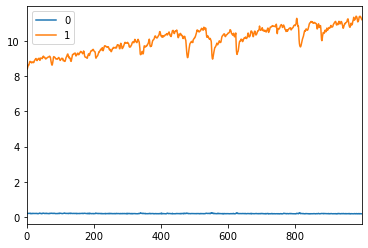

In [147]:
# loss_history = list(map(lambda x: x.numpy(), history))
# # loss_history
df = pd.DataFrame(history)
df.plot()

In [148]:
# Evaluate model
from sklearn.metrics import classification_report

X_te = dataset[4].x
A_te = dataset[4].a
y_te = dataset[4].y

y_pred = model.predict([X_te, A_te], batch_size=X_te.shape[0])
report = classification_report(y_te, (y_pred >= 0.5).astype(int))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       449
         1.0       0.89      1.00      0.94        50

    accuracy                           0.99       499
   macro avg       0.95      0.99      0.97       499
weighted avg       0.99      0.99      0.99       499



In [151]:
from sklearn.metrics import classification_report

X_te = dataset[8].x
A_te = dataset[8].a
y_te = dataset[8].y

y_pred = model.predict([X_te, A_te], batch_size=X_te.shape[0])
report = classification_report(y_te, (y_pred >= 0.5).astype(int))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      3134
         1.0       0.76      0.86      0.81       406

    accuracy                           0.95      3540
   macro avg       0.87      0.91      0.89      3540
weighted avg       0.96      0.95      0.95      3540



In [152]:
(y_pred >= 0.5).astype(int).sum()

457

In [146]:
acc = tf.keras.metrics.binary_accuracy(y_te, y_pred).numpy()
minimum = np.array([(y_te == 0).sum(), (y_te == 1).sum()]).min()
zeroes_index = np.random.choice(np.where(y_te == 0)[0], minimum, replace=False)
ones_index = np.random.choice(np.where(y_te == 1)[0], minimum, replace=False)
mask = np.zeros_like(y_te)
mask[zeroes_index] = 1
mask[ones_index] = 1
# np.multiply(bin_acc, mask).sum()


In [231]:
target = tf.convert_to_tensor(y_te)
minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])[:minimum]
ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])[:minimum]
mask = tf.Variable(tf.zeros_like(target))
stacked_inp = tf.reshape(tf.stack([zeroes_index, ones_index]), (-1,1))
zeros_stack = tf.reshape(tf.stack([stacked_inp, tf.zeros((minimum*2,1), dtype='int64')], axis=1), (-1,2))

In [208]:
target = tf.convert_to_tensor(y_te)
minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
zeroes_index = tf.random.shuffle(tf.where(target == 0))[:minimum, :]
ones_index = tf.random.shuffle(tf.where(target == 1))[:minimum, :]
mask = tf.Variable(tf.zeros_like(target))
stacked_inp = tf.stack([zeroes_index, ones_index], axis=1)

In [232]:
# tf.SparseTensor(stacked_inp, tf.ones((minimum*2, )), target.shape)
zeroes_index.shape, ones_index.shape, stacked_inp.shape, tf.ones((minimum*2, )).shape, target.shape, zeros_stack.shape

(TensorShape([50]),
 TensorShape([50]),
 TensorShape([100, 1]),
 TensorShape([100]),
 TensorShape([499, 1]),
 TensorShape([100, 2]))

In [237]:
sparsed_data = tf.SparseTensor(zeros_stack, tf.ones((minimum*2, )), target.shape)
mask = tf.sparse.to_dense(tf.sparse.reorder(sparsed_data), default_value = 0. )

In [240]:
tf.reduce_sum(densed)

<tf.Tensor: shape=(), dtype=float32, numpy=100.0>

In [200]:
def top_k_filtering( logits, top_k = 5):
    
    # a[...,1] equivalent to a[: ,: ,1 ]
    indices_to_remove = logits < tf.math.top_k(logits,top_k)[0][..., -1, None]
    # indices_to_remove is a tensor of bool values e.g. [ True, False, False, ..., True ]

    # 1d indices
    idx_remove = tf.where( indices_to_remove == 0 )[:,-1]
    idx_keep = tf.where( indices_to_remove == 1 )[:,-1]
    
    values_remove = tf.tile( [-float('inf')], [tf.shape(idx_remove)[0]] ) 
    values_keep = tf.gather( logits[0], idx_keep )

    # to create a sparse vector we still need 2d indices like [ [0,1], [0,2], [0,10] ]
    # create vectors of 0's that we'll later stack with the actual indices
    zeros_remove = tf.zeros_like(idx_remove)
    zeros_keep = tf.zeros_like(idx_keep)

    idx_remove = tf.stack( [ zeros_remove, idx_remove], axis=1 )
    idx_keep = tf.stack( [ zeros_keep, idx_keep], axis=1 )

    # now we can create a sparse matrix
    logits_remove = tf.SparseTensor( idx_remove, values_remove, tf.shape(logits, out_type = tf.int64))
    logits_keep = tf.SparseTensor( idx_keep, values_keep, tf.shape(logits, out_type = tf.int64))

    # add together the two matrices (need to convert them to dense first)
    filtered_logits = tf.add(
        tf.sparse.to_dense(logits_remove, default_value = 0. ),
        tf.sparse.to_dense(logits_keep, default_value = 0. )
    )

    return filtered_logits

In [255]:
tf.sequence_mask([1, 3, 2], target.shape[0])

<tf.Tensor: shape=(3, 432), dtype=bool, numpy=
array([[ True, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False]])>

In [67]:
# from sklearn.manifold import TSNE
# layer_outputs = [layer.output for layer in model.layers]
# activation_model = Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict([X_te, A_te],batch_size=X_te.shape[0])

# #Get t-SNE Representation
# #get the hidden layer representation after the first GCN layer
# x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

In [202]:
# import matplotlib.pyplot as plt
# def plot_tSNE(labels_encoded,x_tsne):
#     color_map = np.argmax(labels_encoded, axis=1)
#     plt.figure(figsize=(10,10))
#     for cl in range(1):
#         indices = np.where(color_map==cl)
#         indices = indices[0]
#         plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
#     plt.legend()
#     plt.show()
    
# plot_tSNE(y_te,x_tsne)

In [13]:
# y_true = [[1], [1], [0], [0]]
# y_pred = [[1], [1], [0], [0]]
tf.keras.metrics.binary_accuracy(y_te, y_pred).numpy()



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1.

In [12]:
(y_te == 0).sum(), (y_te == 1).sum() 

(449, 50)

355

In [226]:
y_true = [[1], [1], [0], [0]]
y_pred = [[0.8], [0.8], [0.3], [0.3]]
m = tf.keras.metrics.binary_accuracy(y_true, y_pred)



In [45]:
y_pred

array([[0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36716142],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.36763102],
       [0.36708796],
       [0.367